# EEG Wheelchair Binary Classification ML Model
## Using 1D Convolutional Networks and Recurrent Networks
This is the first experiment with trying to convert 4 channel EEG brain wave data into a binary classification of stop and go for the EEG wheelchair control system.

## Overview
The following notebook will follow these next steps:
1. Data Cleaning
    - Get rid of inconsistent samples or bad samples
2. Data Preprocessing
    - Convert to wavelet transforms and take signal squeezed signals
3. Data Filtering
    - Filter out irrelevant frequencies and disconnections
4. Build Model
    - Form CNN-RNN network for prediction modelling
5. Model Training
    - Train model on training set of EEG Samples
6. Hyperparameter Optimization
    - Optimize model hyperparameters by cross validation 
7. Model Validation
    - Validate model on test set


![overview diagram](docs/model_overview_diagram.jpg)
![recurrent diagram](docs/recurrent_model_diagram.png)
![cnn diagram](docs/conv_model_diagram.png)

In [6]:
# Basic imports
from datetime import datetime
import numpy as np
import glob
from collections import defaultdict

# Data management
import pandas as pd

# Data processing
from ssqueezepy import ssq_cwt

# Model training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt

## Importing Data

In [2]:
# Read test EEG data from dat directory
test_file = pd.read_csv('data/STOP/dk1_1673481784.csv', header=None)
test_file

,0,1,2,3,4
0,2023-01-11 19:03:05.859334,847.164856,840.584961,868.549622,837.294983
1,2023-01-11 19:03:05.860338,838.940002,837.294983,850.454834,832.360046
2,2023-01-11 19:03:05.860338,837.294983,855.389771,832.360046,835.650024
3,2023-01-11 19:03:05.860338,834.005005,847.164856,847.164856,832.360046
4,2023-01-11 19:03:05.861335,840.584961,852.099792,855.389771,837.294983
...,...,...,...,...,...
3076,2023-01-11 19:03:19.779637,842.229919,888.289368,850.454834,822.490173
3077,2023-01-11 19:03:19.780633,815.910278,868.549622,817.555237,796.170471
3078,2023-01-11 19:03:19.780633,827.425110,863.614685,824.135132,797.815491
3079,2023-01-11 19:03:19.780633,845.519897,858.679749,832.360046,806.040344


In [7]:
# Pull all file data
files = defaultdict(list)
for file in glob.glob('./data/GO/*.csv'):
    files["GO"].append(pd.read_csv(file, header=None))
    
for file in glob.glob('./data/STOP/*.csv'):
    files["STOP"].append(pd.read_csv(file, header=None))
    
for file in glob.glob('./data/REST/*.csv'):
    files["REST"].append(pd.read_csv(file, header=None))

## Convert to wavelet transform signal squeezed

In [21]:
def ts_to_ssq(timeseries):
    """
    Converts 4 channel time series data to ssq wavelet transform
    """
    timestamps, tp9, af7, af8, tp10 = timeseries
    
    # Get the frequency of the samples 
    start = datetime.strptime(str(timestamps[0]), "%Y-%m-%d %H:%M:%S.%f")
    end = datetime.strptime(str(timestamps[-1]), "%Y-%m-%d %H:%M:%S.%f")
    duration = (end-start).total_seconds()
    fs = timestamps.size/duration
    
    Twtp9, _, *_ = ssq_cwt(tp9, fs=fs)
    Twtp10, _, *_ = ssq_cwt(tp10, fs=fs)
    Twaf7, _, *_ = ssq_cwt(af7, fs=fs)
    Twaf8, _, *_ = ssq_cwt(af8, fs=fs)
    
    return np.array((Twtp9, Twaf7, Twaf8, Twtp10))

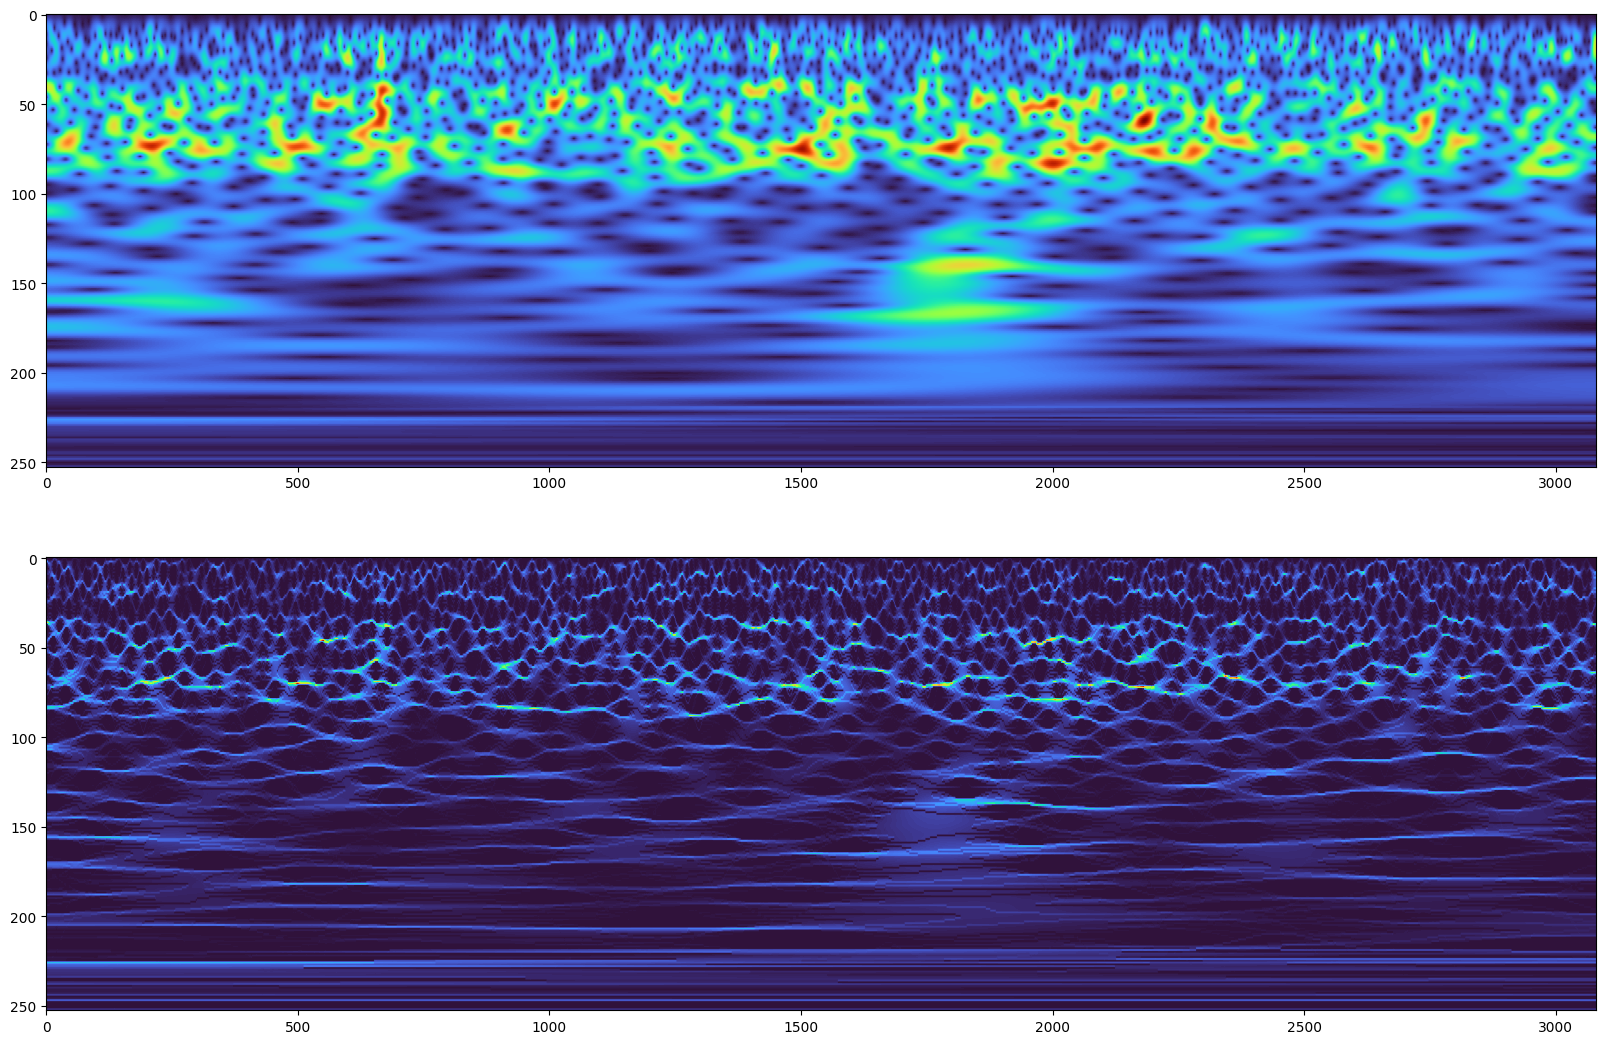

In [8]:
# Try test file

# Convert to numpy arrays
timestamps, tp9, af7, af8, tp10 = test_file.T.to_numpy()

# Get the frequency of the samples 
start = datetime.strptime(str(timestamps[0]), "%Y-%m-%d %H:%M:%S.%f")
end = datetime.strptime(str(timestamps[-1]), "%Y-%m-%d %H:%M:%S.%f")
duration = (end-start).total_seconds()
fs = timestamps.size/duration

Twtp9, Wtp9, *_ = ssq_cwt(tp9, fs=fs)
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(3, 1, 2)
plt.imshow(np.abs(Twtp9), aspect='auto', cmap='turbo')
fig.add_subplot(3, 1, 1)
plt.imshow(np.abs(Wtp9), aspect='auto', cmap='turbo')
plt.show()


In [32]:
# Compile all files into test data
X = []
y = []

num_files = sum([len(x) for x in files.values()])
                
for key, data in files.items():
    for file in data:
        if not num_files%50:
            print("%d files left to convert" % num_files)
        num_files -= 1
                
        # if file is smaller than 3000 samples, don't use it
        if len(file[0]) < 3000:
            continue
        
        # Convert to numpy arrays
        ssq_data = ts_to_ssq((test_file.head(3000).T.to_numpy()))
        X.append(ssq_data)
        y.append(key)
        

192 files left to convert
191 files left to convert
190 files left to convert
189 files left to convert
188 files left to convert
187 files left to convert
186 files left to convert
185 files left to convert
184 files left to convert
183 files left to convert
182 files left to convert
181 files left to convert
180 files left to convert
179 files left to convert
178 files left to convert
177 files left to convert
176 files left to convert
175 files left to convert
174 files left to convert
173 files left to convert


KeyboardInterrupt: 